In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import mne
mne.__version__

'1.4.0'

In [2]:
import sys
path_utils = 'decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [35]:
subjs_list = ['s01', 's02',
            's03','s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' ]
path = 'Cond_CJ_EEG'

In [36]:
epochs = []
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    epochs.append(epoch.average());
    # print(isubj)

gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [37]:
all_epochs = []
all_rawdata = [None] * np.size(subjs_list)
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
    all_rawdata[isubj] =  subj_data
    all_epochs.append(epoch);
    epoch.metadata

In [38]:
all_st_epochs = []
all_st_rawdata = [None] * np.size(subjs_list)
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
    subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
    all_st_rawdata[isubj] =  subj_data
    all_st_epochs.append(epoch);
    epoch.metadata

In [39]:
import DecToolbox as dt

In [40]:
nSubj = np.size(subjs_list)

dec_subj = [None] * nSubj
G = [None] * nSubj

for ival, isubj in enumerate(subjs_list):
    print(ival)
    time = all_st_epochs[ival].times
    label = all_st_epochs[ival].ch_names
    Y = all_st_rawdata[ival]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    Y = np.delete(Y, 25, axis=0)

    X = np.array(all_st_rawdata[ival]['metadata'].orient)
    phi = X
    binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity
    # binned_phi = np.digitize(phi, bins = np.array([  0, 45, 90, 135 ]) ) # bins collapsing degrees by similarity

    numF = Y.shape[0];
    numT = Y.shape[1];
    numN = Y.shape[2];
    numC = 8 # how many channels to use
    G[ival] = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
    binned_phi = (G[ival]-1)*(180/8)
    print(binned_phi)
    CONDS = np.unique(G[ival])
    nConds = CONDS.size
    nfold = 5
    FoldsIdx = dt.CreateFolds(G[ival], Y, nfold)
    #numC = 8 # how many channels to use

    cfg = dict()
    cfg['kappa'] = 4
    cfg['NumC'] = numC
    cfg['Tuning'] = 'vonmises'#'halfRectCos'
    cfg['offset'] = 0

    design, sortedesign = dt.stim_features(binned_phi, cfg)
    
    Xhat = np.zeros([numC,numN, numT])
    for it in range(numT):
        cfg = dict()
        cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        cfg['cfgD'] = {'demean' : 'traindata'}
        Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)
    
    dec_subj[ival] = Xhat   

0
[135.   22.5  90.  ...   0.   45.  157.5]
1
[112.5  22.5 135.  ...  90.    0.    0. ]
2
[  0.   90.   45.  ... 157.5 157.5  22.5]
3
[ 22.5 135.   22.5 ...  90.   22.5 135. ]
4
[112.5  22.5 135.  ...  45.  157.5  90. ]
5
[135.  135.  135.  ...   0.   45.   67.5]
6
[ 67.5  22.5   0.  ...   0.  112.5  22.5]
7
[ 45.   22.5  67.5 ... 112.5   0.  135. ]
8
[ 90.   22.5   0.  ... 135.    0.   22.5]
9
[135.   90.   90.  ... 157.5  22.5 135. ]
10
[ 90.   22.5  67.5 ... 135.   45.   90. ]
11
[135.   45.  112.5 ...  45.   90.  157.5]
12
[ 90.   90.   45.  ...  45.  157.5  45. ]
13
[ 0.  67.5 90.  ... 90.  67.5 67.5]
14
[112.5  90.  112.5 ... 135.   90.   45. ]
15
[ 67.5  45.    0.  ...   0.  135.   67.5]
16
[135.   22.5   0.  ...  45.    0.   67.5]
17
[112.5 112.5 157.5 ...  67.5   0.  157.5]
18
[112.5   0.   90.  ...   0.  135.  135. ]
19
[ 45.    0.   22.5 ...  90.   67.5 135. ]
20
[90.  67.5  0.  ... 45.  67.5 22.5]
21
[ 45.  135.  112.5 ...  67.5  45.    0. ]
22
[157.5 157.5   0.  ...  45.  

In [41]:
m_centered = np.zeros((numC,numC, numT, nSubj))
for ival, isubj in enumerate(subjs_list):
    Zhat = dec_subj[ival]
    Zhat_centered = 0*Zhat.copy()
    
    for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
        Zhat_centered[:, G[ival] == (ic+1),:] = np.roll(Zhat[:,G[ival] == (ic+1),:], -ic, axis = 0)
        m_centered[:,ic, :, ival] =  np.mean( Zhat_centered[:,  G[ival] == (ic+1), :], axis = 1)

In [42]:
m_centered.shape

(8, 8, 201, 26)

In [43]:
Zhat_centeredmean = np.mean( m_centered, axis = 1)
Zhat_centeredmean = np.mean( Zhat_centeredmean, axis = 2)

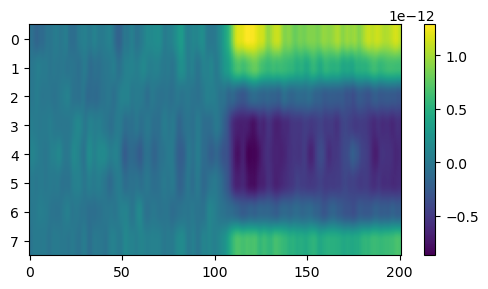

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Zhat_centeredmean,aspect='auto')
plt.colorbar()


In [45]:
Zhat_centered.shape

(8, 1542, 201)

In [46]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Zhat_centeredmean = np.mean(Zhat_centered, axis = 1)
#Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Zhat_shiftedmean = np.roll(Zhat_centeredmean, 3, axis = 0)
#Xhat_shiftedsem = np.roll(Zhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

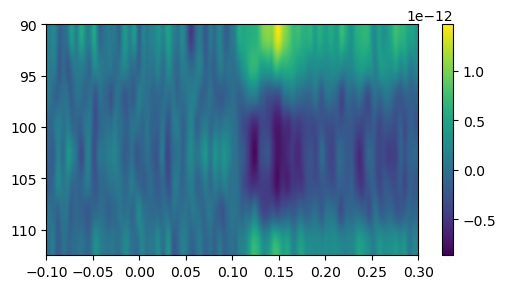

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Zhat_centeredmean,aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()
